Training Logistic Regression
Training Decision Tree
Training Random Forest
Training SVM


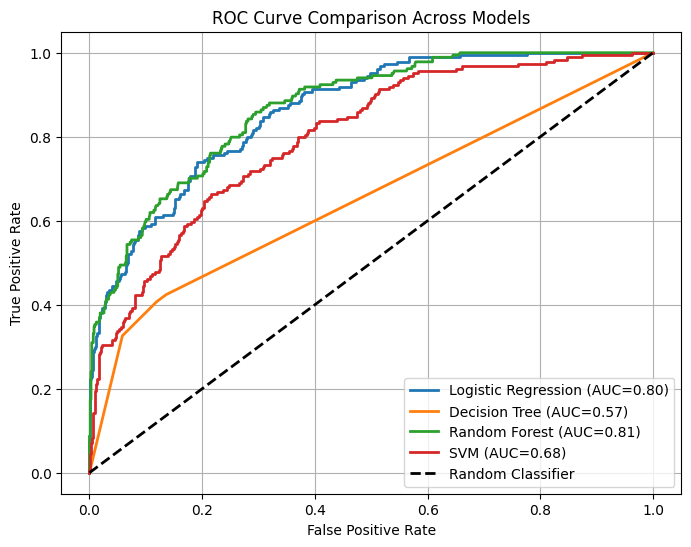


Model Performance Metrics:

                     Accuracy  Precision    Recall  F1-score       AUC
Logistic Regression  0.576087   0.499440  0.576087  0.523944  0.800030
Decision Tree        0.369565   0.520202  0.369565  0.422462  0.566063
Random Forest        0.576087   0.539942  0.576087  0.552814  0.813781
SVM                  0.472826   0.492587  0.472826  0.391643  0.677370
Supervised learning completed!


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.linear_model import LogisticRegression as LogReg

# Load data and selected features
df_encoded = pd.read_csv('data/heart_disease.csv')
X = df_encoded.drop("target", axis=1)
y = df_encoded["target"]

# 1) Feature Importance using Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# 2) Recursive Feature Elimination (RFE)
model = LogReg(max_iter=5000, solver="saga", random_state=42)
rfe = RFE(model, n_features_to_select=10)
X_rfe = rfe.fit_transform(X, y)
selected_features_rfe = X.columns[rfe.support_]

# 3) Chi-Square Test
X_chi2 = SelectKBest(score_func=chi2, k=10)
X_chi2_fit = X_chi2.fit_transform(X.abs(), y)
chi2_features = X.columns[X_chi2.get_support()]

# 4) Final reduced dataset
selected_features = list(set(selected_features_rfe).union(set(chi2_features)))
X_reduced = X[selected_features]


# Supervised Learning: Classification Models
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, solver="lbfgs", random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}
open("results/evaluation_metrics.txt", "w").close()
results = {}
plt.figure(figsize=(8, 6))

for name, model in models.items():
    print(f"Training {name}")
    clf = OneVsRestClassifier(model)
    clf.fit(X_train, y_train)
  
    y_pred = clf.predict(X_test)  
    y_prob = clf.predict_proba(X_test) 

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    try:
        auc_score = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
    except:
        auc_score = 0.5  
    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-score": f1,
        "AUC": auc_score
    }
    with open("results/evaluation_metrics.txt", "a") as f:
      f.write(f"{name}\n")
      f.write("-" * 20 + "\n")
      f.write(f"Accuracy: {acc:.4f}\n")
      f.write(f"Precision: {prec:.4f}\n")
      f.write(f"Recall: {rec:.4f}\n")
      f.write(f"F1-score: {f1:.4f}\n")
      f.write(f"AUC: {auc_score:.4f}\n\n")

    # each model gets a ROC curve
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={auc_score:.2f})")

# Plot ROC Curve
plt.plot([0, 1], [0, 1], "k--", lw=2, label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison Across Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Show results in table
df_results = pd.DataFrame(results).T
print("\nModel Performance Metrics:\n")
print(df_results)
print("Supervised learning completed!")